In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2 

%matplotlib inline

number_of_videos = 3

data = np.load('data/MOVIE/videos/0.npy')
print("Datashape: " + str(data.shape))

Datashape: (24, 128, 128, 3)


K-Means Clustering on Pixel based on color doesnt work

X, Y, R, G, B
[[ 35.93478261  62.35767663  25.86185462  21.29775815  20.50730299]
 [ 96.57978723  31.30800405  22.16466565  18.7856383   18.19430091]
 [ 31.10738007  19.99372694  19.32686347  16.81350554  15.49405904]
 [ 96.99177378  95.90411311  21.96910026  17.68257069  18.77946015]
 [ 31.70677732 105.79149378  19.12105809  15.1846473   14.06794606]]


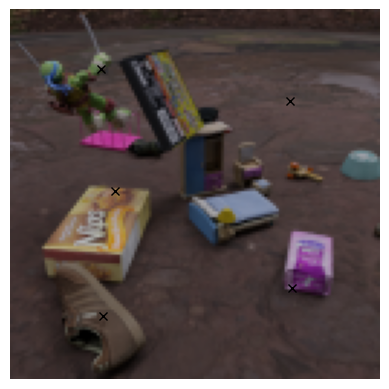

In [3]:
import math
from sklearn.cluster import KMeans

%matplotlib inline

def cluter_points(data, num_clusters, color_scaling=1, dist_scaling=1, height=128, width=128):
    posarr = np.zeros((128,128,2))

    for h in range(height):
        for w in range(width):
            posarr[h][w][0] = w
            posarr[h][w][1] = h
    

    posarr = posarr * dist_scaling
    data = data * color_scaling

    points = np.concatenate((posarr,data), axis=2).reshape(height*width, 5)
    k_mean = KMeans(n_clusters=num_clusters, init="k-means++", ).fit(points)

    print("X, Y, R, G, B")
    print(k_mean.cluster_centers_)

    clusters = np.delete(k_mean.cluster_centers_, [2,3,4], 1)

    return clusters

def display_clusterpoints( data, clusters, ax):
    ax.imshow(data)

    for cluster in clusters:
        ax.plot(cluster[0], cluster[1], marker="x", color="blacK")
        ax.axis('off')


clusters = cluter_points(data[0], 5, color_scaling=0.3)
display_clusterpoints(data[0], clusters, plt.gca())

Slow flooding
- Place clusters all over the image
- Calculate a mean and a std of cluster (global and local)
- have some unite parameters that rises slowly, once neighboring pixel/clusters get to close, they get united

0.03978659940916551
0.02061156474669475


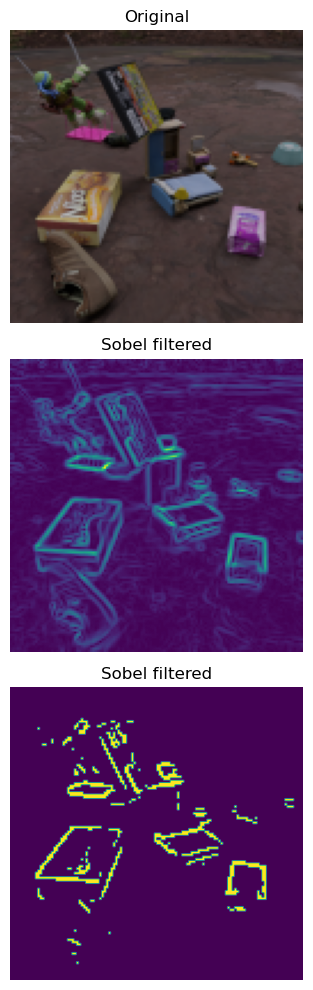

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, color, morphology
from skimage.segmentation import flood, flood_fill


data = np.load('data/MOVIE/videos/0.npy')

point = (64,64)
im = data[0].copy()
im_sobel = filters.sobel(data[0][..., 0])

fig, ax = plt.subplots(nrows=3, figsize=(5, 10))

ax[0].imshow(im)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(im_sobel)
ax[1].set_title('Sobel filtered')
ax[1].axis('off')


print(im_sobel.mean())
print(np.median(im_sobel))

ax[2].imshow(im_sobel>0.15)
ax[2].set_title('Sobel filtered')
ax[2].axis('off')

fig.tight_layout()
plt.show()

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

rand = (8318,  95146, 176100)

for x in range(number_of_videos):
    data = np.load('data/MOVIE/videos/'+str(x)+'.npy')
    data2 = np.load('data/MOVIE/segmentations/'+str(x)+'.npy')

    frameSize = (data.shape[1], data.shape[2])
    filename = "videos/"+str(x)+"_default_video.mp4"
    out = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)
    filename = "videos/"+str(x)+"_annotations.mp4"
    out2 = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

    for x,y in zip(data,data2):
        out.write(x)

        
        
        mask = np.stack((y.copy()*rand[0], y.copy()*rand[1], y.copy()*rand[2]), 2).astype(np.uint8).squeeze()
        out2.write(mask)
        

    out.release()

# Dense optical Flow

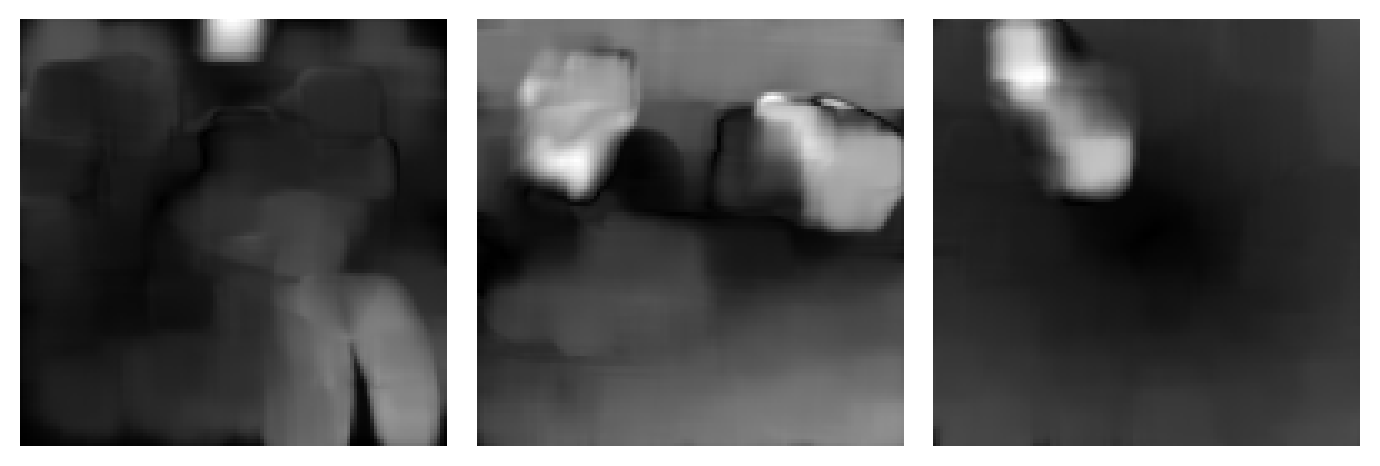

In [6]:
fig = plt.figure(figsize=(7, 10), dpi=200)


for i,x in enumerate((247, 184, 137)):
    try:
        os.mkdir("videos/"+str(x))
    except:
        pass

    data = np.load('data/MOVIE/videos/'+str(x)+'.npy')

    prvs = cv2.cvtColor(data[0], cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(data[0])

    next = cv2.cvtColor(data[1], cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    fig.add_subplot(1,3,i+1)
    plt.imshow(rgb)
    plt.axis("off")

fig.tight_layout()
plt.savefig('download.jpg', bbox_inches='tight')

# Sparse optical flow 

105.94970703125
85.886962890625
142.505126953125
145.38484700520834


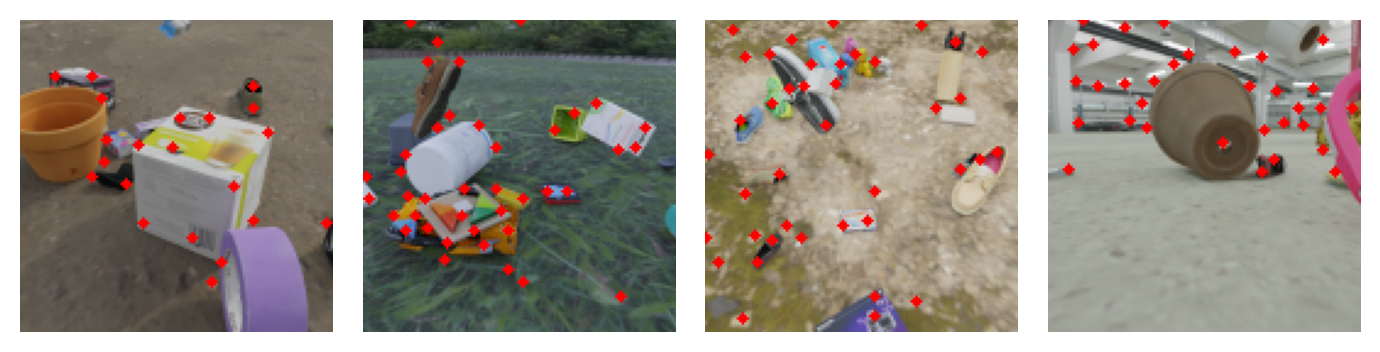

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 10), dpi=200)


for f,x in enumerate((247, 184, 137, 6)):
    data = np.load('data/MOVIE/videos/'+str(x)+'.npy')

    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.1,
                        minDistance = 7,
                        blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                    maxLevel = 2,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Take first frame and find corners in it
    old_frame = data[0]
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_RGB2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    mask = np.zeros_like(old_frame)

    frame = data[1]

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel().astype(int)
        c,d = old.ravel().astype(int)

        mask = cv2.line(mask, (a,b),(c,d), (255, 0, 0) , 2)
        frame = cv2.circle(frame,(a,b),2, (255, 0, 0) ,-1)
    rgb = frame
    fig.add_subplot(1,4,f+1)
    plt.imshow(rgb)
    print(rgb.mean())
    plt.axis("off")

fig.tight_layout()
plt.savefig('download.jpg', bbox_inches='tight')

# Shi Tomasi Feature Tracking Parameter Testing

/tmp/ipykernel_3502401/3983377090.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


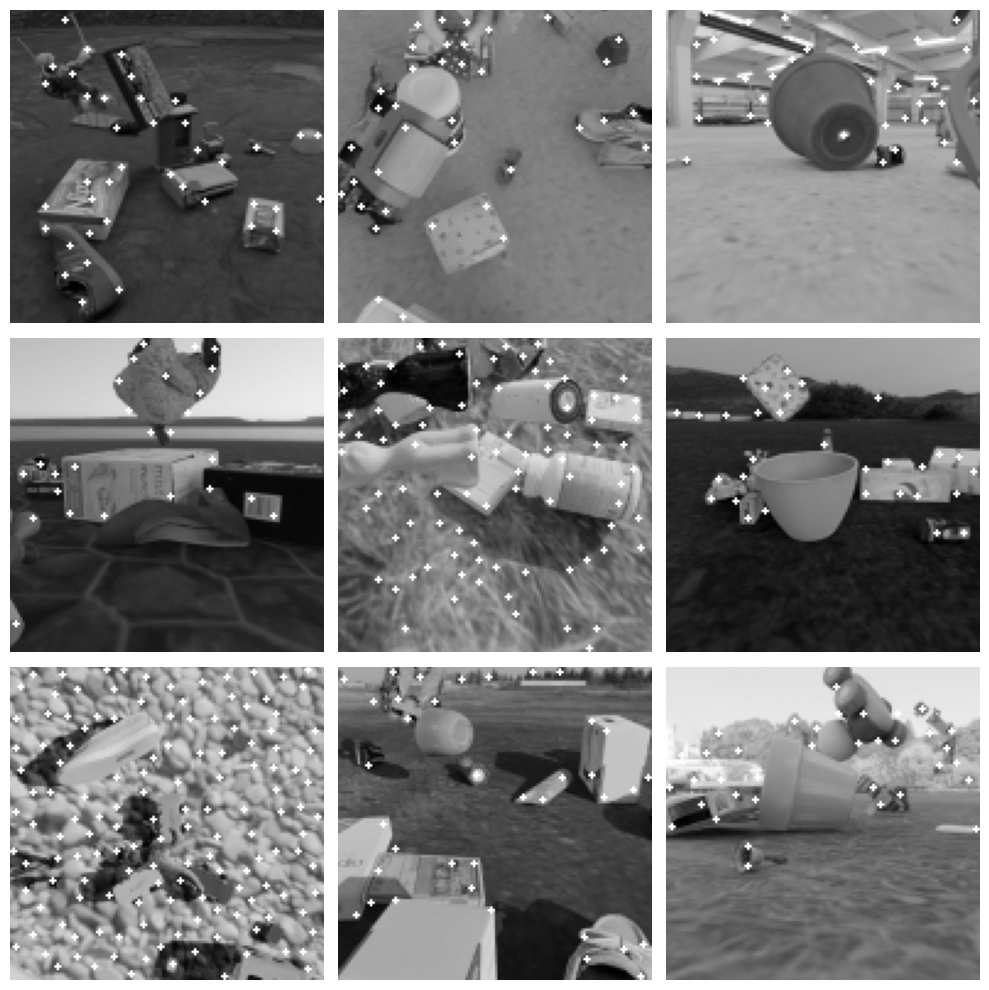

In [8]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))

feature_params = dict( maxCorners = 1000,
                    qualityLevel = 0.1,
                    minDistance = 7,
                    blockSize = 7 )

for i in range(9):
    a = i%3
    b = int(i/3)

    data = np.load('data/MOVIE/videos/'+str(i)+'.npy')

    img = data[0]
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
 
    corners = cv2.goodFeaturesToTrack(gray,mask = None,**feature_params)

    corners = np.int0(corners)
 
    for ii in corners:
        x,y = ii.ravel()
        cv2.circle(gray,(x,y),1,255,-1)

    ax[a][b].imshow(gray, cmap='gray')
    ax[a][b].axis('off')

fig.tight_layout()
plt.show()
 


# Segment Anything

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

In [10]:
image = np.load('data/MOVIE/videos/0.npy')[0]

import sys
sys.path.append("..")

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "model/vit_b.pth"
model_type = "vit_b"

torch.cuda.set_device(7)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)

/user/georg.eckardt/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 7 has a total capacity of 23.67 GiB of which 4.44 MiB is free. Process 2875672 has 616.00 MiB memory in use. Process 3613104 has 11.83 GiB memory in use. Process 3666354 has 10.89 GiB memory in use. Including non-PyTorch memory, this process has 344.00 MiB memory in use. Of the allocated memory 119.55 MiB is allocated by PyTorch, and 22.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# NEXT STEP, CREATE VIDEO OF THE SEGMENTATIONS BY SAM

68
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


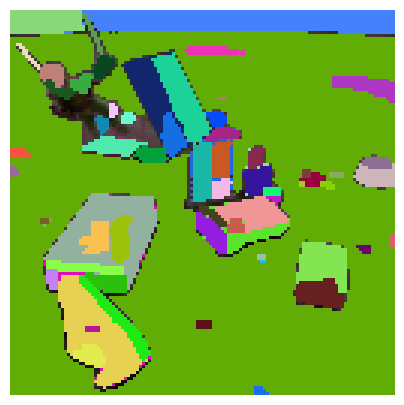

In [ ]:
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 


In [ ]:
import numpy as np
import cv2

extracted_features = 10

list_of_colors = [np.random.random(3) for x in range(extracted_features)] 


for i in range(number_of_videos):
    print(i)
    image = np.load('data/MOVIE/videos/'+str(i)+'.npy')

    name = 'videos/'+str(i)+'_sam_at_'+str(extracted_features)+'_features.mp4'
    vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)
    name = 'videos/'+str(i)+'_sam_background_reduction.mp4'
    vid2 = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)
     
    for im in image:
        bw_im = cv2.cvtColor(cv2.cvtColor(im.copy(),cv2.COLOR_RGB2GRAY),cv2.COLOR_GRAY2RGB)
                             
        masks = mask_generator.generate(im.copy())

        # find background mask
        max_i = 0
        max = 0
        for j,mask in enumerate(masks):
            if mask["area"] > max:
                max = mask["area"]
                max_i = j
        
        bg = im.copy()
        largest_mask = masks[max_i]["segmentation"]
        
        mask = np.stack((np.zeros(largest_mask.shape).astype(bool), np.zeros(largest_mask.shape).astype(bool), largest_mask.copy()), 2)
        bg[mask] = 255
        vid2.write(bg)

        # extract x masks
        extracted_masks = []

        for i,x in enumerate(masks):
            extracted_masks.append(x)
            if i == extracted_features:
                break

        for x in extracted_masks:
            mask = x["segmentation"]
            
            mask = np.stack((np.zeros(mask.shape).astype(bool), np.zeros(mask.shape).astype(bool), mask.copy()), 2)
            im[mask] = 255
        
        vid.write(im)
    
    vid.release()
    vid2.release()


0


# Test YOLO

In [11]:
import torch

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_yolo_mask(raw_image, masks):
    fig, axes = plt.subplots(1, 1, figsize=(15, 15))
    axes.imshow(np.array(raw_image))
    axes.axis("off")

    for mask in masks:
      show_box( [mask[0],mask[1],mask[2],mask[3]], axes)
    plt.show()

def yolo_eval_batch( model, batch, threshhold ):
    res = []
    
    for x in batch:
        t = model(x).xyxy[0].to("cpu").numpy()
        res.append( t )
    # structure xmin, ymin, xmax, ymax, confidence, type
    return res


# Define Yolo

print(torch.cuda.is_available())
model = torch.hub.load('ultralytics/yolov5', 'yolov5x6', device="cpu", pretrained=True, _verbose=False)
torch.cuda.set_device(4)
model.to("cuda")
print("done")

True


Using cache found in /user/georg.eckardt/.cache/torch/hub/ultralytics_yolov5_master


done


2
1
1


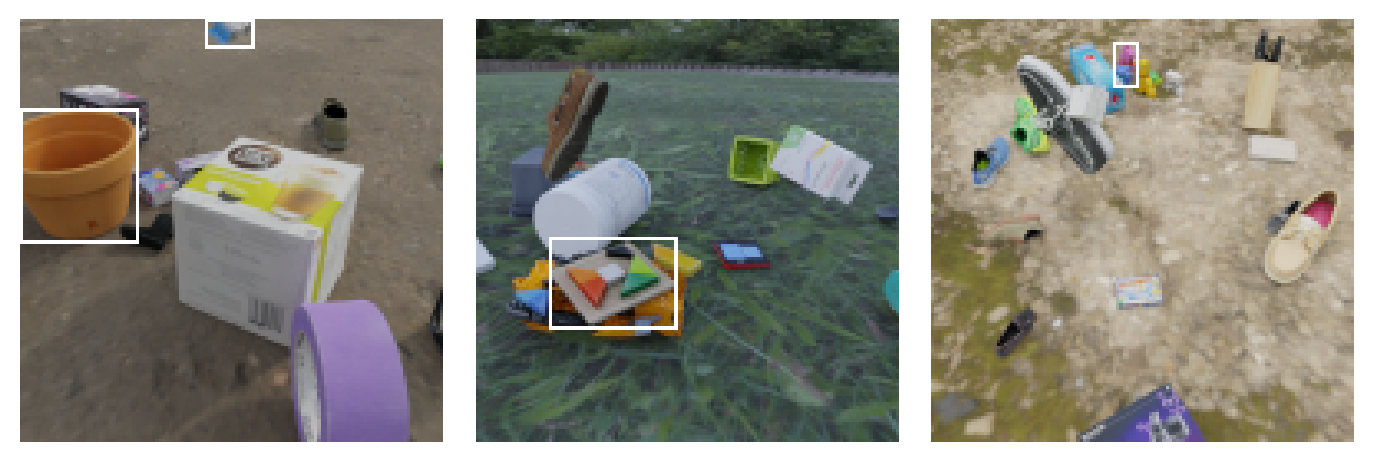

In [16]:
%matplotlib inline
import os
import cv2

fig = plt.figure(figsize=(7, 10), dpi=200)


for i,x in enumerate((247, 184, 137)):
    try:
        os.mkdir("videos/"+str(x))
    except:
        pass

    data = np.load('data/MOVIE/videos/'+str(x)+'.npy')

    masks = yolo_eval_batch( model, data, 0 )

    img = data[1]
    mask = masks[1]

    print(len(mask))
    for box in mask:
        img = cv2.rectangle(img, ( int(box[0]), int(box[1])), ( int(box[2]), int(box[3])), (255,255,255), 1)
        
    
    fig.add_subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis("off")

fig.tight_layout()
plt.savefig('download.jpg', bbox_inches='tight')

# Segemention (connected compontents + multi-Otsu threshold )

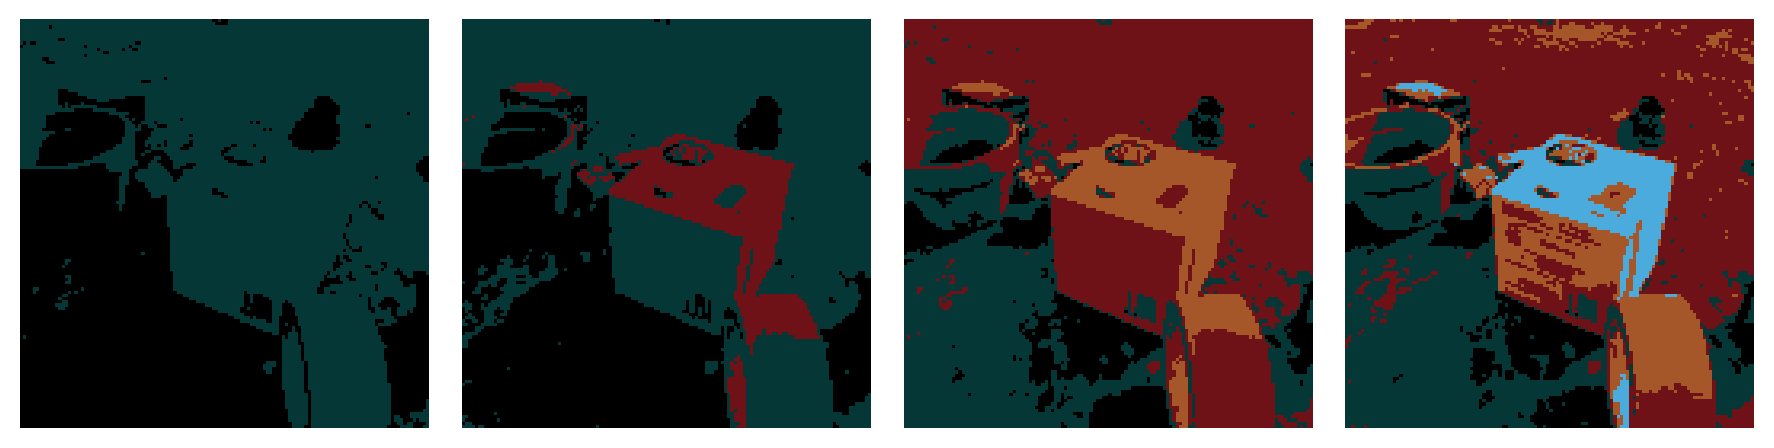

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import cv2
from skimage.filters import threshold_multiotsu
import skimage

frameSize = (128,128)


fig = plt.figure(figsize=(9, 6), dpi=200)

for i, num_class in enumerate((2,3,4,5)):
    fig.add_subplot(1,4, i+1)
    i = 247
    image = np.load('data/MOVIE/videos/'+str(i)+'.npy')

    im = image[0]
    im = cv2.cvtColor(im.copy(),cv2.COLOR_RGB2GRAY)


    thresholds = threshold_multiotsu(im, classes=num_class)
    regions = np.digitize(im, bins=thresholds).astype(np.uint8)

    #regions = skimage.morphology.label(regions,2)

    regs_random = np.stack((regions.copy()*345, regions.copy()*234, regions.copy()*567), 2).astype(np.uint8)
    regs_random = cv2.cvtColor(regs_random.copy(),cv2.COLOR_HSV2RGB)
    
    plt.imshow(regs_random)
    plt.axis("off")

fig.tight_layout()
plt.savefig('download.jpg', bbox_inches='tight')

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import cv2
from skimage.filters import threshold_multiotsu
import skimage
from skimage.segmentation import chan_vese

%matplotlib inline

rand = (np.random.rand(3)*100)
rand[0] *= 100
rand[1] *= 1000
rand[2] *= 10000
rand = rand.astype(int)
print(rand)

rand = (8318,  95146, 176100)

for i in range(number_of_videos):
    image = np.load('data/MOVIE/videos/'+str(i)+'.npy')

    name = 'videos/'+str(i)+'chan_vese.mp4'
    vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

    for x in image:
        im = x
        im = cv2.cvtColor(im.copy(),cv2.COLOR_RGB2HSV)

        cv = chan_vese(
                cv2.cvtColor(x.copy(),cv2.COLOR_RGB2GRAY),
                mu=0.1,
                lambda1=1,
                lambda2=1,
                tol=1e-5,
                max_num_iter=200,
                dt=0.5,
                init_level_set="checkerboard",
        )

        im = np.stack((cv.copy()*255, cv.copy()*128, cv.copy()*25), 2).astype(np.uint8)
        
        vid.write(im)
    vid.release()


[  3335  30922 214626]


# Sam with sparse flow points

In [32]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

sam_checkpoint = "model/vit_b.pth"
model_type = "vit_b"

torch.cuda.set_device(6)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda")

predictor = SamPredictor(sam)

In [35]:
for i in range(10):
    frameSize = (128,128)

    data = np.load('data/MOVIE/videos/'+str(i)+'.npy')

    feature_params = dict( maxCorners = 1000,
                        qualityLevel = 0.1,
                        minDistance = 5,
                        blockSize = 5 )


    name = 'videos/'+str(i)+'default.mp4'
    vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

    name = 'videos/'+str(i)+'sam_with_sparse_flow.mp4'
    vid2 = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

    for frame in data:
        img = frame

        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        corners = cv2.goodFeaturesToTrack(gray,mask = None,**feature_params).squeeze()
        
        predictor.set_image(img)
        mask, _, _  = predictor.predict( point_coords=corners, point_labels=np.ones(corners.shape[0]), multimask_output=True )
        mask = mask[2]
        im = np.stack((mask.copy()*255, mask.copy()*255, mask.copy()*255), 2).astype(np.uint8)    
        vid.write(im)

        for x in corners:
           img = cv2.circle(img, (int(x[0]), int(x[1])), 1, (255, 0, 0))
        
        vid2.write(img)

    vid.release()
    vid2.release()

# Sobel Filter to Video

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

model_type = "vit_b"
sam_checkpoint = "model/"+model_type+".pth"

torch.cuda.set_device(7)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda")

predictor = SamPredictor(sam)

/user/georg.eckardt/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import numpy as np
import sys

%matplotlib inline

def calc_color_mean( points, size):
    return points.sum()/size
    

def calc_center( mask ):
    coords = np.where(mask==True)
    x = coords[0].sum() / coords[0].shape
    y = coords[1].sum() / coords[1].shape

    return int(y), int(x)

def calc_iou(im_1, im_2):
    intersection = np.logical_and(im_1, im_2)
    union = np.logical_or(im_1,im_2)

    return np.sum(intersection)/np.sum(union)

def iteration_layer(min_value, min_arr, current_arr, level, masks, starting_index=0):
    if level == 0:
        uni_map = np.zeros((128,128))
        for x in range(len(current_arr)):
            uni_map += masks[current_arr[x]] 
        full_score = np.absolute(uni_map-1).sum()   
        # check for new best
        if full_score < min_value:
            min_arr = current_arr.copy()
            del current_arr[-1]
            return full_score, min_arr
        else:
            del current_arr[-1]
            return min_value, min_arr
    
    for i in range(starting_index,len(masks)):
        current_arr.append(i)
        min_value, min_arr = iteration_layer(min_value, min_arr, current_arr, level-1, masks, i+1)
        
    try:
        del current_arr[-1]
    except:
        pass
    return min_value, min_arr

def calc_best_subset(masks, num_masks, min_masks):
    # PERFORMANCE BOOST: Sort out masks with very high overlap and try the out later
    # Sort out masks with clear cut boundaries
    min_value = float("inf")
    min_arr = []

    # add empty masks
    for i in range(num_masks-min_masks):
        masks.append(np.zeros((128,128)))
    
    min_value, min_arr = iteration_layer(min_value, min_arr, [], num_masks, masks)

    return min_arr

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, color, morphology
from skimage.segmentation import flood, flood_fill
import skimage
import math
import os
import random


%matplotlib inline

color_grad_for_fusing = 10
distance_for_fusing = 15
iou_error = 0.55
number_of_mask_final_assamble = 10


for i in range(1):
    try:
        os.mkdir("images/"+str(i)+"/")
    except:
        pass
    frameSize = (128,128)

    data = np.load('data/MOVIE/videos/'+str(i)+'.npy')
    an = np.load('data/MOVIE/segmentations/'+str(i)+'.npy')
    an = np.stack( ( an[0].copy()*255, an[0].copy()*128, an[0].copy()*56 ), 2).astype(np.uint8).squeeze() 
    
    name = 'videos/image_'+str(i)+'_points.mp4'
    vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

    name = 'videos/'+str(i)+'_with_sam.mp4'
    vid3 = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

    for x in data:
        x = cv2.cvtColor(x,cv2.COLOR_BGR2HSV)
    
    for frame in data:
        image = frame.copy()
        image2 = image.copy()
        sobel = []

        for j in range(3):
            sobel.append( filters.sobel(frame[..., j])  )

        sobel = np.array(sobel)
        sobel = ( sobel[0] + sobel[1] + sobel[2] )/3 

        sobel = np.digitize(sobel, bins=[sobel.mean()]).astype(np.uint8)
        regions = skimage.morphology.label(sobel,1)

        save = np.stack( ( regions.copy()*234, regions.copy()*345, regions.copy()*567 ), 2).astype(np.uint8)  
        cv2.imwrite("images/"+str(i)+"/sobel_segmentation.jpg", save)

        center = []
        color_mean = []
        for k in range(np.unique(regions).shape[0]):
            area = regions == k
            size = area.sum()
            center.append( calc_center(area) )
            color_mean.append( calc_color_mean( area  * ((frame[..., 0] + frame[..., 1] + frame[..., 2] )/3).astype(np.uint8), size ))

        
        # fuse and remove pointers
        for n in range(len(center)):
            for m in range(len(center)):
                if n != m and math.sqrt(abs(center[n][0] - center[m][0])**2 + abs(center[n][1] - center[m][1])**2) < distance_for_fusing and abs(color_mean[n]-color_mean[m]) < color_grad_for_fusing:
                    regions += (regions == m)*(n-m)

        # restore counting from 0        
        regions = np.digitize(regions, bins=np.unique(regions))-1
        #print(regions.max())
        save = np.stack( ( regions.copy()*255, regions.copy()*128, regions.copy()*56 ), 2).astype(np.uint8)    
        cv2.imwrite("images/"+str(i)+"/regions.jpg", save)
        #plt.imshow(regions, cmap="prism")


        # recalculated center
        center = []
        color_mean = []
        for k in range(np.unique(regions).shape[0]):
            area = regions == k
            center.append( calc_center(area) )
        

        # Predict Masks for all points (check if better with negative points)
        mask_all = []
        score_all = []
        predictor.set_image(image2)
        for point in center:
            point = np.expand_dims(np.array(point), axis=0)
            mask, score, _  = predictor.predict( point_coords=point, point_labels=[1])
            mask_all.append(mask[0])
            score_all.append(score[0])

        '''
        # calc coexistance matrix
        coexistance = np.zeros((len(mask_all),len(mask_all)))   
        '''

        # unify masks
        len_mask_all = len(mask_all)
        iou_err = np.zeros((len_mask_all,len_mask_all))

        for n in range(len_mask_all):
            for m in range(n):
                if n != m:
                    iou = calc_iou(mask_all[n], mask_all[m])
                    iou_err[n][m] = iou
                    iou_err[m][n] = iou

        remove_list = []
        for n in range(len_mask_all):
            for m in range(len_mask_all):
                if n != m and n not in remove_list and iou_err[n][m] > iou_error:
                    mask_all[n] = np.logical_or(mask_all[n],mask_all[m])
                    remove_list.append(m)
        
        # remove remove_list
        new_masks = []
        new_center = []
        for x in range(len_mask_all):
            if x not in remove_list:
                new_center.append(center[x])
                new_masks.append(mask_all[x])
        center = new_center
        mask_all = new_masks
        print(len(mask_all))
        
        # save images
        for c in range(len(mask_all)):
            save = np.stack( ( mask_all[c].copy()*255, mask_all[c].copy()*128, mask_all[c].copy()*56 ), 2).astype(np.uint8)    
            save = cv2.circle( save, (int(center[c][0]), int(center[c][1])), 3, (255, 255, 255) )
            cv2.imwrite("images/"+str(i)+"/"+str(c)+".jpg", save)
        
        # save annotation
        for x in range(len(mask_all)):
            an = cv2.circle( an, (int(center[x][0]), int(center[x][1])), 3, (255, 255, 255) )
        cv2.imwrite("images/"+str(i)+"/ann.jpg", an)
        

        # Calc best Subset
        min_arr = calc_best_subset(mask_all, number_of_mask_final_assamble, 2)
        final = np.zeros((128,128))
        for f, ids in enumerate(min_arr):
            final += mask_all[ids]*(f+1)
        final = np.stack( ( final.copy()*234, final.copy()*345, final.copy()*567 ), 2).astype(np.uint8)  
        cv2.imwrite("images/"+str(i)+"/final.jpg", final)
        cv2.imwrite("images/"+str(i)+"/without.jpg", frame)

        break
    
        #print(len_mask_all-len(remove_list))
        uni_mask = np.zeros((128,128))        
        for c in range(len_mask_all):
            if c not in remove_list:
                uni_mask += mask_all[c]*(c + 10)
        
        # write masks
        im = np.stack((uni_mask.copy()*255, uni_mask.copy()*128, uni_mask.copy()*56), 2).astype(np.uint8)    
        vid3.write(im)
        
    vid.release()
    vid3.release()

18


KeyboardInterrupt: 